## bibliotecas e funções

In [7]:
# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN
import duckdb as dd

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#definindo quantidade de linhas e colunas visiveis
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [8]:
# Graficos ############################
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

plt.style.use('dark_background')
plt.style.use('seaborn-v0_8-whitegrid')

import seaborn as sns
custom_palette = sns.color_palette("bright")
sns.palplot(custom_palette)
sns.set_palette("bright")
sns.set_style('whitegrid') #cor da grade(fundo)

# Definindo o estilo de fonte e tema
import matplotlib.font_manager as fm #para alterar as fontes dos graficos
fonte = fm.FontProperties(family="Calibri", style="italic")
%matplotlib inline

In [9]:
# Copia e cola
import pyperclip

# Manipulação de Strings
from unidecode import unidecode #unidecode(string)
import re # Regex

# Controle de Erros
import traceback

# Manipualação de datas
from datetime import *

In [10]:
# Carregando minhas funções de analise de dados e criação de modelos
import requests

url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'funcoes_estatisticas' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'ML_supervised_learning' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

def aval_modelo_corte_tabela(y_true, y_probs_positivas, beta = 1.5, pontos_de_corte = np.arange(10, 100, 10)):
    y_probs_positivas = np.array(y_probs_positivas)
    # Inicializando um DataFrame para armazenar as métricas
    fd = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp'])

    # Loop pelos pontos de corte
    for threshold in pontos_de_corte:
        previsoes_personalizadas = (y_probs_positivas >= threshold).astype(int)

        # Calculando os valores de tn, fp, fn, tp
        tn = len(np.where((previsoes_personalizadas == 0) & (y_true == 0))[0])
        fp = len(np.where((previsoes_personalizadas == 1) & (y_true == 0))[0])
        
        fn = len(np.where((previsoes_personalizadas == 0) & (y_true == 1))[0])
        tp = len(np.where((previsoes_personalizadas == 1) & (y_true == 1))[0])

        # Adicionando os resultados ao DataFrame 'fd'
        fd = pd.concat([fd, pd.DataFrame([[threshold, tn, fp, fn, tp]], columns=fd.columns)])

    # Substituir valores NaN por 0
    fd.fillna(0, inplace=True)
    fd.reset_index(drop=True, inplace=True)
    ######################################################################################

    # Inicializar as colunas das métricas com NaN
    metricas_de_aval = ['acuracia', 'precisao', 'sensibilidade', 'especificidade', 'f1', #'fb_score',
                        # 'valor_pre_posi', 'valor_pre_neg', 'taxa_falsos_positivos', 'taxa_falsos_negativos',
                        'custo_who','fraude_evitada','fraude_tomada','delta']#,
                        # 'fdr', 'fo_r', 'indice_youden', 'coef_matthews']
    fd[metricas_de_aval] = 0

    # Loop para calcular as métricas em cada linha
    for i in range(len(fd)):
        # Acurácia
        if (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i]) != 0:
            fd['acuracia'][i] = (fd['tp'][i] + fd['tn'][i]) / (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i])

        # Precisão
        if (fd['tp'][i] + fd['fp'][i]) != 0:
            fd['precisao'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # Sensibilidade (Recall)
        if (fd['tp'][i] + fd['fn'][i]) != 0:
            fd['sensibilidade'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fn'][i])

        # Especificidade
        if (fd['tn'][i] + fd['fp'][i]) != 0:
            fd['especificidade'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fp'][i])

        # F1-Score
        if (fd['precisao'][i] + fd['sensibilidade'][i]) != 0:
            fd['f1'][i] = 2 * (fd['precisao'][i] * fd['sensibilidade'][i]) / (fd['precisao'][i] + fd['sensibilidade'][i])

        # # Valor Preditivo Positivo
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['valor_pre_posi'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # Valor Preditivo Negativo
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['valor_pre_neg'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Taxa de Falsos Positivos
        # fd['taxa_falsos_positivos'][i] = 1 - fd['especificidade'][i]

        # # Taxa de Falsos Negativos
        # fd['taxa_falsos_negativos'][i] = 1 - fd['sensibilidade'][i]

        fd['custo_who'][i] = (fd['tp'][i] + fd['fp'][i]) * 10.0
        fd['fraude_evitada'][i] = fd['tp'][i] * 8000
        fd['fraude_tomada'][i] = fd['fn'][i] * 8000
        fd['delta'][i] = fd['fraude_evitada'][i] - fd['custo_who'][i] - fd['fraude_tomada'][i]

        # # False Discovery Rate (FDR)
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['fdr'][i] = fd['fp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # False Omission Rate (FOR)
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['fo_r'][i] = fd['fn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Índice de Youden
        # fd['indice_youden'][i] = fd['sensibilidade'][i] + fd['especificidade'][i] - 1

        # try:
        #     # Coeficiente de Matthews (MCC)
        #     denom_matthews = (fd['tp'][i]+fd['fp'][i])*(fd['tp'][i]+fd['fn'][i])*(fd['tn'][i]+fd['fp'][i])*(fd['tn'][i]+fd['fn'][i])
        #     if denom_matthews != 0:
        #         fd['coef_matthews'][i] = (fd['tp'][i]*fd['tn'][i] - fd['fp'][i]*fd['fn'][i]) / np.sqrt(denom_matthews)
        # except:
        #     fd['coef_matthews'][i] = np.nan

        # # F-beta Score
        # denom_fb_score = (beta**2 * fd['valor_pre_posi'][i]) + fd['sensibilidade'][i]
        # if denom_fb_score != 0:
        #     fd['fb_score'][i] = (1 + beta**2) * (fd['valor_pre_posi'][i] * fd['sensibilidade'][i]) / denom_fb_score

    fd[metricas_de_aval] = fd[metricas_de_aval].round(5)
    return fd

print('TUDO OK')

https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/funcoes_estatisticas.py
https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/ML_supervised_learning.py
TUDO OK


In [11]:
def tabela_cont(df, linha, coluna):
    a = df.groupby([linha, coluna]).size().unstack()
    for i in a.columns:
        a[i].fillna(0, inplace = True)
        a[i] = a[i].apply(lambda x: int(x))
    return a

def count_table_percent(df, linha, coluna, opcao):
    result = tabela_cont(df, linha, coluna)
    if opcao == 'Linha':
        return round(result.div(result.sum(axis=1), axis=0) * 100, 2)
    elif opcao == 'Coluna':
        return round(result.div(result.sum(), axis=1) * 100, 2)
    else:
        return 'Opção invalida'

In [74]:
from sklearn.ensemble import BaggingClassifier

# Função para plotar a importância das características de um modelo
def feature_importance_emsamble(modelo, x_columns):

    # Função para calcular a importância média das características no BaggingClassifier
    def feature_importance_bagging(modelo, x_columns):
        if hasattr(modelo, 'estimators_'):
            # Verificar se os estimadores possuem feature_importances_
            importancias = [tree.feature_importances_ for tree in modelo.estimators_ if hasattr(tree, 'feature_importances_')]
            if len(importancias) > 0:
                # Calcula a média das importâncias
                media_importancias = np.mean(importancias, axis=0)
                return pd.DataFrame({'colunas': x_columns, 'importancia': media_importancias})

    # Verificar se o modelo possui o atributo feature_importances_
    if hasattr(modelo, 'feature_importances_'):
        importancias = pd.DataFrame({'colunas': x_columns, 
                                     'importancia': modelo.feature_importances_})
    elif isinstance(modelo, BaggingClassifier):
        importancias = feature_importance_bagging(modelo, x_columns)
    else:
        print(f"O modelo não possui feature_importances_.")
        return

    importancias = importancias.sort_values(by='importancia', ascending=False)
    return importancias

def plot_importancias(tabela_feature_importance):
    plt.figure(figsize=(10, 12))
    sns.barplot(x='importancia', y='colunas', data=tabela_feature_importance, palette='viridis')
    # plt.title(f'Importância das Características - {nome_modelo}')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.show()

### carregando dataframe

In [13]:
# df = pd.read_csv('dados_consolidados.csv', sep=';')
df = pd.read_parquet('dados_consolidados.parquet')
df_bck = df.copy()
print(df.shape)
df.sample(3)

(2208221, 73)


,CIDADE_CADASTRO,COD_BENEFICIO,COD_LOJA_ATIVACAO,COD_LOJA_OFICIAL,COD_SIGLA,COD_SOLICBENEFICIO,COD_STATUS,COMPARA_LOJA,COMPARA_LOJA_UF,COMPARA_NASC,DATA_BIOMETRIA,DES_DOCUMENTO,DES_DOCUMENTO_bin,DES_MEIOPAGAMENTO,DES_METODO,DIAS_ATIVACAO,DIAS_ATIVACAO2,DIAS_ATIVACAO2_bin,DIAS_ATIVACAO_bin,DIA_SEMANA,DIA_SEMANA_qtde_fraudes_6meses,DIF_DATA_MIN,DIF_DATA_MIN_bin,DTAHRA_INI_SOLICITACAO,DTA_CONTROLE,DTA_INI_SOLICITACAO,DTA_INI_SOLICITACAO_menos6meses,DTA_NASCIMENTO,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,DTA_VALIDADE_CREDITO,DTH_INCLUSAO,IDADE,IDADE_CAT10_10,IDADE_CAT10_10_qtde_fraudes_6meses,INDEXX,NOME_LOJA_ATIVACAO,NOME_LOJA_OFICIAL,NOM_ESPECIEBENEFICIO,NOM_ESPECIEBENEFICIO2,NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses,NOM_PAPELPESSOA,NUM_BENEFICIO,NUM_CPF,NUM_LOTEPREGAO,PRACA,QTDE_CPFS_COM_MESMO_TELEFONE,QTDE_TELEFONES_COMPARTILHADOS,SCORE_UNICO,SCORE_UNICO_CAT,SCORE_UNICO_CAT_qtde_fraudes_6meses,SEQ_ORGAOPAGADOR,SLG_SEXO,STATUS_WHO,TELEFONE_COMPARTILHADO,TIPO_BENEFICIO,TPO_DOCUMENTO,TPO_DOCUMENTO_bin,UF_CADASTRO,UF_CADASTRO_REGIAO,UF_CADASTRO_REGIAO_qtde_fraudes_6meses,UF_CADASTRO_qtde_fraudes_6meses,UF_LOJA_ATIVACAO,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,UF_LOJA_OFICIAL,VLR_TOTALCREDITO,VLR_TOTALCREDITO_1000em1000,VLR_TOTALCREDITO_500em500,VLR_TOTALCREDITO_bin,Y,beneficio_de_risco,beneficios_que_tiveram_fraude,comparacao_cadastro_unico_e_bene
1764193,LAGARTO,2866580,2780,2780,MBL,3046552,33,1,1,0,2024-04-24,DOCUMENTO DE IDENTIFICACAO,1,CONTA CORRENTE,CreateProcess,1.0,-13.0,0,0,Wednesday,31,-298.650000,0,24/04/2024 11:51:21,24/04/2024 12:29:15,2024-04-24,2023-10-24,1971-09-10,1971-09-10,1971-09-10,2024-05-07,2024-04-23,52.0,50–59,35,1764193,FILIAL VOLTA REDONDA - RJ,FILIAL VOLTA REDONDA - RJ,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,AUXILIO DOENCA PREVIDENCIARIO,47,TITULAR,6490032167,02690425718,10,PRACA ANTIGA,1.0,0.0,95.0,Aprovado e Confiavel Unico Check,29,590,1,Não_Analisado,0,0,1,1,RJ,Sudeste,86,57,RJ,58,RJ,4611.75,4000–4999,4500–4999,0,0,1,1,1
1538316,SANTO AMARO,2747756,6481,6481,RPA_INSS,2963404,33,1,1,0,2024-03-20,DOCUMENTO DE IDENTIFICACAO,1,CONTA CORRENTE,CreateProcess,15.0,1.0,0,1,Wednesday,30,-256.050000,0,20/03/2024 10:59:57,20/03/2024 12:22:39,2024-03-20,2023-09-20,1988-06-23,1988-06-23,1988-06-23,2024-03-19,2024-03-05,35.0,30–39,18,1538316,FILIAL BARRA SALVADOR BA,FILIAL BARRA SALVADOR BA,AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA,DEFICIENCIA,17,TITULAR,2238065649,07408644598,15,PRACA ANTIGA,1.0,0.0,10.0,Face Nova e Desconhecida,5,160,0,Não_Analisado,0,1,1,1,BA,Nordeste,43,6,BA,6,BA,22250.26,15000+,15000+,1,0,0,1,1
242039,ACU,2624264,6023,6023,None,2793154,33,1,1,0,None,DOCUMENTO DE IDENTIFICACAO,1,CARTAO MAGNETICO,None,2.0,-12.0,0,0,Thursday,17,-201.833333,0,04/01/2024 09:37:15,04/01/2024 10:13:36,2024-01-04,2023-07-04,1977-06-23,1977-06-23,1977-06-23,2024-01-16,2024-01-02,46.0,40–49,11,242039,FILIAL MACAIBA RN,FILIAL MACAIBA RN,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,AUXILIO DOENCA PREVIDENCIARIO,22,TITULAR,6471641013,02765575495,24,PRACA ANTIGA,2.0,0.0,0.0,Sem Biometria,105,676,0,Não_Analisado,0,0,1,1,RN,Nordeste,33,1,RN,1,RN,15123.33,15000+,15000+,1,0,1,1,1


In [14]:
df['ANO_MES'] = pd.to_datetime(df['DTA_INI_SOLICITACAO'], errors='coerce')
df['ANO_MES'] = df['ANO_MES'].dt.strftime('%Y%m')
df['ANO_MES'] = df['ANO_MES'].astype(int)

# Aplicando filtros =========================================================
print(df.shape)
lista_unico = ['Erro - N Validado','Face Nova e Desconhecida','Reprovado 1:1','Reprovado Unico Check','Sem Biometria']
df = df[df['SCORE_UNICO_CAT'].isin(lista_unico)].reset_index(drop=True)
# df = df[df['SCORE_UNICO'] == 0].reset_index(drop=True)

# criterio1 = ~( (df['Y'] == 0) & (df['ANO_MES'] < 202310) )
# criterio2 = ~( (df['Y'] == 0) & (df['ANO_MES'] >= 202503) )
# df = df[criterio1 & criterio2].sort_values(by='DTA_INI_SOLICITACAO').reset_index(drop=True)
print(df.shape)
# ===========================================================================

df = df.sort_values(by='DTA_INI_SOLICITACAO').reset_index(drop=True)
df['INDEXX'] = df.index

df.groupby(['ANO_MES','Y']).size().unstack().fillna(0).round(0)

(2208221, 74)
(954526, 74)


Y,0,1
ANO_MES,,
202301,31185.0,18.0
202302,28451.0,3.0
202303,27634.0,4.0
202304,29260.0,0.0
202305,39926.0,2.0
202306,47892.0,1.0
202307,55034.0,2.0
202308,74774.0,6.0
202309,69727.0,5.0


In [15]:
tipos_colunas = pd.DataFrame(df.dtypes).reset_index()
display(tipos_colunas)
# tipos_colunas.to_excel('tipo_colunas.xlsx', index=False)

,index,0
0,CIDADE_CADASTRO,object
1,COD_BENEFICIO,object
2,COD_LOJA_ATIVACAO,object
3,COD_LOJA_OFICIAL,object
4,COD_SIGLA,object
...,...,...
69,Y,int64
70,beneficio_de_risco,int64
71,beneficios_que_tiveram_fraude,int64
72,comparacao_cadastro_unico_e_bene,int64


# =========================================

In [16]:
# df = df_bck.copy()

# excluindo colunas não usadas no modelo

In [17]:
drop_colunas = [
'DTA_CONTROLE',

'DTA_INI_SOLICITACAO','DTAHRA_INI_SOLICITACAO',
'DTA_INI_SOLICITACAO_menos6meses',

'DTH_INCLUSAO',

'DTA_NASCIMENTO',
'COD_BENEFICIO',
'COD_SOLICBENEFICIO',
'NUM_BENEFICIO',
'NUM_CPF',
'DTA_NASCIMENTO_CAD_BENE',

'SEQ_ORGAOPAGADOR',
'NUM_LOTEPREGAO',

'COD_STATUS',
'COMPARA_NASC',

'NOM_ESPECIEBENEFICIO',

'COD_LOJA_ATIVACAO',
'NOME_LOJA_ATIVACAO',

'COD_LOJA_OFICIAL',
'NOME_LOJA_OFICIAL',

'DTA_VALIDADE_CREDITO',

'CIDADE_CADASTRO',
'QTDE_CPFS_COM_MESMO_TELEFONE',
'QTDE_TELEFONES_COMPARTILHADOS',

'DATA_BIOMETRIA',
'DES_METODO',
'COD_SIGLA',
'DTA_NASCIMENTO_CADUNICO',

'DES_DOCUMENTO', 'DES_DOCUMENTO_bin',
'TPO_DOCUMENTO', 'TPO_DOCUMENTO_bin',
'DES_MEIOPAGAMENTO',

'STATUS_WHO',
]
df_colunas_excluidas = df[drop_colunas].copy()
df_colunas_excluidas['INDEXX'] = df['INDEXX']
df = df.drop(drop_colunas, axis=1)

sorted(df.columns)

['ANO_MES',
 'COMPARA_LOJA',
 'COMPARA_LOJA_UF',
 'DIAS_ATIVACAO',
 'DIAS_ATIVACAO2',
 'DIAS_ATIVACAO2_bin',
 'DIAS_ATIVACAO_bin',
 'DIA_SEMANA',
 'DIA_SEMANA_qtde_fraudes_6meses',
 'DIF_DATA_MIN',
 'DIF_DATA_MIN_bin',
 'IDADE',
 'IDADE_CAT10_10',
 'IDADE_CAT10_10_qtde_fraudes_6meses',
 'INDEXX',
 'NOM_ESPECIEBENEFICIO2',
 'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
 'NOM_PAPELPESSOA',
 'PRACA',
 'SCORE_UNICO',
 'SCORE_UNICO_CAT',
 'SCORE_UNICO_CAT_qtde_fraudes_6meses',
 'SLG_SEXO',
 'TELEFONE_COMPARTILHADO',
 'TIPO_BENEFICIO',
 'UF_CADASTRO',
 'UF_CADASTRO_REGIAO',
 'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
 'UF_CADASTRO_qtde_fraudes_6meses',
 'UF_LOJA_ATIVACAO',
 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
 'UF_LOJA_OFICIAL',
 'VLR_TOTALCREDITO',
 'VLR_TOTALCREDITO_1000em1000',
 'VLR_TOTALCREDITO_500em500',
 'VLR_TOTALCREDITO_bin',
 'Y',
 'beneficio_de_risco',
 'beneficios_que_tiveram_fraude',
 'comparacao_cadastro_unico_e_bene']

In [18]:
display(df[df['Y'] == 1].isnull().sum().sort_values(ascending=False).reset_index().head(10))

,index,0
0,COMPARA_LOJA,0
1,COMPARA_LOJA_UF,0
2,TELEFONE_COMPARTILHADO,0
3,TIPO_BENEFICIO,0
4,UF_CADASTRO,0
5,UF_CADASTRO_REGIAO,0
6,UF_CADASTRO_REGIAO_qtde_fraudes_6meses,0
7,UF_CADASTRO_qtde_fraudes_6meses,0
8,UF_LOJA_ATIVACAO,0
9,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,0


In [19]:
display(df.isnull().sum().sort_values(ascending=False).reset_index().head(15))
print(df.shape)
print(df['Y'].value_counts())

df = df.dropna()
print(df.shape)
print(df['Y'].value_counts())

df_colunas_excluidas = df_colunas_excluidas.loc[df.index]

,index,0
0,UF_CADASTRO,195
1,UF_CADASTRO_REGIAO,195
2,UF_LOJA_ATIVACAO,20
3,NOM_ESPECIEBENEFICIO2,15
4,VLR_TOTALCREDITO_500em500,7
5,PRACA,7
6,NOM_PAPELPESSOA,7
7,UF_LOJA_OFICIAL,7
8,VLR_TOTALCREDITO_1000em1000,7
9,VLR_TOTALCREDITO,7


(954526, 40)
Y
0    954191
1       335
Name: count, dtype: int64
(954296, 40)
Y
0    953961
1       335
Name: count, dtype: int64


In [20]:
df_bck_sem_colunas_e_linhas_inuteis = df.copy()

# Tratando dados

In [21]:
# from sklearn.preprocessing import LabelEncoder
# # Variavel Dependente
# y = df[['Y','INDEXX']] # Processar a variável dependente (Y)
# y = y.set_index('INDEXX', drop=False)
# # y = LabelEncoder().fit_transform(y)

# df = df.drop('Y', axis=1)
# y

In [22]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
OneHotEncoder(handle_unknown='ignore', sparse_output=True)

from pandas.api.types import is_numeric_dtype, is_object_dtype, is_bool_dtype


def tratando_dados(x):

    # 1. Detectar colunas categóricas automaticamente
    colunas_categoricas = x.select_dtypes(include=['object', 'category']).columns.tolist()
    # 2. Filtrar apenas as colunas categóricas com mais de 2 categorias (não binárias)
    colunas_categoricas_nao_binarias = [col for col in colunas_categoricas if x[col].nunique(dropna=False) > 2]

    # 2. Criar transformador
    one_hot = make_column_transformer(
        (OneHotEncoder(drop='if_binary', sparse_output=False), colunas_categoricas_nao_binarias),
        remainder='passthrough'  # mantém as colunas numéricas
    )

    # 3. Aplicar transformação
    x_transformado = one_hot.fit_transform(x)

    # 4. Recuperar os nomes das novas colunas
    nomes_colunas = one_hot.get_feature_names_out()

    # 5. Transformar em DataFrame
    x = pd.DataFrame(x_transformado, columns=nomes_colunas)
    nomes_colunas_limpos = [nome.split('__')[-1] for nome in nomes_colunas]
    x.columns = nomes_colunas_limpos
    # x['Y'] = y

    # 6. Resetar o índice (opcional, se o índice anterior foi perdido)
    # x.reset_index(drop=True, inplace=True)

    # 7. Listar os nomes das colunas finais
    x_columns = x.columns.tolist()

    return x

### separando as variaveis categoricas com varias categorias para tratar com onehot

In [23]:
# # 1. Detectar colunas categóricas automaticamente
# colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
# # 2. Filtrar apenas as colunas categóricas com mais de 2 categorias (não binárias)
# colunas_categoricas_nao_binarias = [col for col in colunas_categoricas if df[col].nunique(dropna=False) > 2]

# # print(colunas_categoricas_nao_binarias0)
# print(colunas_categoricas_nao_binarias)

# df_cat_tratados = tratando_dados(df[colunas_categoricas_nao_binarias])
# print(sorted(df_cat_tratados.columns))
# display(df_cat_tratados.head(3))

# df_bin_num = df[[col for col in df.columns if col not in colunas_categoricas_nao_binarias]]
# print(sorted(df_bin_num.columns))
# display(df_bin_num.head(3))

#######################################################################################
# colunas = df_bin_num.columns.to_list() + df_cat_tratados.columns.to_list()
# df = pd.DataFrame(np.concatenate((df_bin_num.to_numpy(), df_cat_tratados.to_numpy()), 1), columns=colunas)

In [24]:
df = tratando_dados(df)
df = df[sorted(df.columns)]
df['INDEXX'] = df['INDEXX'].astype('int64')
df = df.set_index('INDEXX', drop=False)
df.sample(3)

,ANO_MES,COMPARA_LOJA,COMPARA_LOJA_UF,DIAS_ATIVACAO,DIAS_ATIVACAO2,DIAS_ATIVACAO2_bin,DIAS_ATIVACAO_bin,DIA_SEMANA_Friday,DIA_SEMANA_Monday,DIA_SEMANA_Saturday,DIA_SEMANA_Thursday,DIA_SEMANA_Tuesday,DIA_SEMANA_Wednesday,DIA_SEMANA_qtde_fraudes_6meses,DIF_DATA_MIN,DIF_DATA_MIN_bin,IDADE,IDADE_CAT10_10_0–9,IDADE_CAT10_10_100–109,IDADE_CAT10_10_10–19,IDADE_CAT10_10_20–29,IDADE_CAT10_10_30–39,IDADE_CAT10_10_40–49,IDADE_CAT10_10_50–59,IDADE_CAT10_10_60–69,IDADE_CAT10_10_70–79,IDADE_CAT10_10_80–89,IDADE_CAT10_10_90–99,IDADE_CAT10_10_qtde_fraudes_6meses,INDEXX,NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO,NOM_ESPECIEBENEFICIO2_APOSENTADORIA,NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO,NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO,NOM_ESPECIEBENEFICIO2_DEFICIENCIA,NOM_ESPECIEBENEFICIO2_LOES,NOM_ESPECIEBENEFICIO2_MATERNIDADE,NOM_ESPECIEBENEFICIO2_OUTROS,NOM_ESPECIEBENEFICIO2_PENSAO,NOM_ESPECIEBENEFICIO2_TRABALHO,NOM_ESPECIEBENEFICIO2_UNIAO,NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses,NOM_PAPELPESSOA_REPRESENTANTE LEGAL,NOM_PAPELPESSOA_TERCEIRO,NOM_PAPELPESSOA_TITULAR,PRACA_PRACA ANTIGA,PRACA_PRACA NOVA,PRACA_PRACA_NAO_LISTADA,SCORE_UNICO,SCORE_UNICO_CAT_Erro - N Validado,SCORE_UNICO_CAT_Face Nova e Desconhecida,SCORE_UNICO_CAT_Reprovado 1:1,SCORE_UNICO_CAT_Reprovado Unico Check,SCORE_UNICO_CAT_Sem Biometria,SCORE_UNICO_CAT_qtde_fraudes_6meses,SLG_SEXO,TELEFONE_COMPARTILHADO,TIPO_BENEFICIO,UF_CADASTRO_AC,UF_CADASTRO_AL,UF_CADASTRO_AM,UF_CADASTRO_AP,UF_CADASTRO_BA,UF_CADASTRO_CE,UF_CADASTRO_DF,UF_CADASTRO_ES,UF_CADASTRO_GO,UF_CADASTRO_MA,UF_CADASTRO_MG,UF_CADASTRO_MS,UF_CADASTRO_MT,UF_CADASTRO_PA,UF_CADASTRO_PB,UF_CADASTRO_PE,UF_CADASTRO_PI,UF_CADASTRO_PR,UF_CADASTRO_REGIAO_Centro-Oeste,UF_CADASTRO_REGIAO_Nordeste,UF_CADASTRO_REGIAO_Norte,UF_CADASTRO_REGIAO_Sudeste,UF_CADASTRO_REGIAO_Sul,UF_CADASTRO_REGIAO_qtde_fraudes_6meses,UF_CADASTRO_RJ,UF_CADASTRO_RN,UF_CADASTRO_RO,UF_CADASTRO_RR,UF_CADASTRO_RS,UF_CADASTRO_SC,UF_CADASTRO_SE,UF_CADASTRO_SP,UF_CADASTRO_TO,UF_CADASTRO_qtde_fraudes_6meses,UF_LOJA_ATIVACAO_AC,UF_LOJA_ATIVACAO_AL,UF_LOJA_ATIVACAO_AM,UF_LOJA_ATIVACAO_AP,UF_LOJA_ATIVACAO_BA,UF_LOJA_ATIVACAO_CE,UF_LOJA_ATIVACAO_DF,UF_LOJA_ATIVACAO_ES,UF_LOJA_ATIVACAO_GO,UF_LOJA_ATIVACAO_MA,UF_LOJA_ATIVACAO_MG,UF_LOJA_ATIVACAO_MS,UF_LOJA_ATIVACAO_MT,UF_LOJA_ATIVACAO_PA,UF_LOJA_ATIVACAO_PB,UF_LOJA_ATIVACAO_PE,UF_LOJA_ATIVACAO_PI,UF_LOJA_ATIVACAO_PR,UF_LOJA_ATIVACAO_RJ,UF_LOJA_ATIVACAO_RN,UF_LOJA_ATIVACAO_RO,UF_LOJA_ATIVACAO_RR,UF_LOJA_ATIVACAO_RS,UF_LOJA_ATIVACAO_SC,UF_LOJA_ATIVACAO_SE,UF_LOJA_ATIVACAO_SP,UF_LOJA_ATIVACAO_TO,UF_LOJA_ATIVACAO_qtde_fraudes_6meses,UF_LOJA_OFICIAL_AC,UF_LOJA_OFICIAL_AL,UF_LOJA_OFICIAL_AM,UF_LOJA_OFICIAL_AP,UF_LOJA_OFICIAL_BA,UF_LOJA_OFICIAL_CE,UF_LOJA_OFICIAL_DF,UF_LOJA_OFICIAL_ES,UF_LOJA_OFICIAL_GO,UF_LOJA_OFICIAL_MA,UF_LOJA_OFICIAL_MG,UF_LOJA_OFICIAL_MS,UF_LOJA_OFICIAL_MT,UF_LOJA_OFICIAL_PA,UF_LOJA_OFICIAL_PB,UF_LOJA_OFICIAL_PE,UF_LOJA_OFICIAL_PI,UF_LOJA_OFICIAL_PR,UF_LOJA_OFICIAL_RJ,UF_LOJA_OFICIAL_RN,UF_LOJA_OFICIAL_RO,UF_LOJA_OFICIAL_RR,UF_LOJA_OFICIAL_RS,UF_LOJA_OFICIAL_SC,UF_LOJA_OFICIAL_SE,UF_LOJA_OFICIAL_SP,UF_LOJA_OFICIAL_TO,VLR_TOTALCREDITO,VLR_TOTALCREDITO_1000em1000_0–999,VLR_TOTALCREDITO_1000em1000_10000–10999,VLR_TOTALCREDITO_1000em1000_1000–1999,VLR_TOTALCREDITO_1000em1000_11000–11999,VLR_TOTALCREDITO_1000em1000_12000–12999,VLR_TOTALCREDITO_1000em1000_13000–13999,VLR_TOTALCREDITO_1000em1000_15000+,VLR_TOTALCREDITO_1000em1000_2000–2999,VLR_TOTALCREDITO_1000em1000_3000–3999,VLR_TOTALCREDITO_1000em1000_4000–4999,VLR_TOTALCREDITO_1000em1000_5000–5999,VLR_TOTALCREDITO_1000em1000_6000–6999,VLR_TOTALCREDITO_1000em1000_7000–7999,VLR_TOTALCREDITO_1000em1000_8000–8999,VLR_TOTALCREDITO_1000em1000_9000–9999,VLR_TOTALCREDITO_500em500_0–499,VLR_TOTALCREDITO_500em500_10000–10499,VLR_TOTALCREDITO_500em500_1000–1499,VLR_TOTALCREDITO_500em500_10500–10999,VLR_TOTALCREDITO_500em500_11000–11499,VLR_TOTALCREDITO_500em500_11500–11999,VLR_TOTALCREDITO_500em500_12000–12499,VLR_TOTALCREDITO_500em500_12500–12999,VLR_TOTALCREDITO_500em

In [25]:
tipos_colunas = pd.DataFrame(df.dtypes).reset_index()
display(tipos_colunas)
# tipos_colunas.to_excel('tipo_colunas.xlsx', index=False)

,index,0
0,ANO_MES,object
1,COMPARA_LOJA,object
2,COMPARA_LOJA_UF,object
3,DIAS_ATIVACAO,object
4,DIAS_ATIVACAO2,object
...,...,...
193,VLR_TOTALCREDITO_bin,object
194,Y,object
195,beneficio_de_risco,object
196,beneficios_que_tiveram_fraude,object


In [26]:
for i in range(3, len(df.columns), 3):
    print(sorted(df.columns)[i-3:i])

['ANO_MES', 'COMPARA_LOJA', 'COMPARA_LOJA_UF']
['DIAS_ATIVACAO', 'DIAS_ATIVACAO2', 'DIAS_ATIVACAO2_bin']
['DIAS_ATIVACAO_bin', 'DIA_SEMANA_Friday', 'DIA_SEMANA_Monday']
['DIA_SEMANA_Saturday', 'DIA_SEMANA_Thursday', 'DIA_SEMANA_Tuesday']
['DIA_SEMANA_Wednesday', 'DIA_SEMANA_qtde_fraudes_6meses', 'DIF_DATA_MIN']
['DIF_DATA_MIN_bin', 'IDADE', 'IDADE_CAT10_10_0–9']
['IDADE_CAT10_10_100–109', 'IDADE_CAT10_10_10–19', 'IDADE_CAT10_10_20–29']
['IDADE_CAT10_10_30–39', 'IDADE_CAT10_10_40–49', 'IDADE_CAT10_10_50–59']
['IDADE_CAT10_10_60–69', 'IDADE_CAT10_10_70–79', 'IDADE_CAT10_10_80–89']
['IDADE_CAT10_10_90–99', 'IDADE_CAT10_10_qtde_fraudes_6meses', 'INDEXX']
['NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO', 'NOM_ESPECIEBENEFICIO2_APOSENTADORIA', 'NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO']
['NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO', 'NOM_ESPECIEBENEFICIO2_DEFICIENCIA', 'NOM_ESPECIEBENEFICIO2_LOES']
['NOM_ESPECIEBENEFICIO2_MATERNIDADE', 'NOM_ESPECIEBENEFICIO2_OUTROS', 'NOM_ESPECIEBENEFICIO2_

In [27]:
for col in df.columns:
    qtde_levels = len(df[col].unique())
    if qtde_levels == 2:
        df[col] = df[col].astype(int)
        print(col, '->', 'int')
    else:
        try:
            df[col] = df[col].astype(float)
            print(col, '->', 'float')
        except:
            print(f"Não foi possível converter a coluna '{col}' para float.")

ANO_MES -> float
COMPARA_LOJA -> int
COMPARA_LOJA_UF -> int
DIAS_ATIVACAO -> float
DIAS_ATIVACAO2 -> float
DIAS_ATIVACAO2_bin -> int
DIAS_ATIVACAO_bin -> int
DIA_SEMANA_Friday -> int
DIA_SEMANA_Monday -> int
DIA_SEMANA_Saturday -> int
DIA_SEMANA_Thursday -> int
DIA_SEMANA_Tuesday -> int
DIA_SEMANA_Wednesday -> int
DIA_SEMANA_qtde_fraudes_6meses -> float
DIF_DATA_MIN -> float
DIF_DATA_MIN_bin -> int
IDADE -> float
IDADE_CAT10_10_0–9 -> int
IDADE_CAT10_10_100–109 -> int
IDADE_CAT10_10_10–19 -> int
IDADE_CAT10_10_20–29 -> int
IDADE_CAT10_10_30–39 -> int
IDADE_CAT10_10_40–49 -> int
IDADE_CAT10_10_50–59 -> int
IDADE_CAT10_10_60–69 -> int
IDADE_CAT10_10_70–79 -> int
IDADE_CAT10_10_80–89 -> int
IDADE_CAT10_10_90–99 -> int
IDADE_CAT10_10_qtde_fraudes_6meses -> float
INDEXX -> float
NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO -> int
NOM_ESPECIEBENEFICIO2_APOSENTADORIA -> int
NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO -> int
NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO -> int
NOM_ESPECIEBENEFICIO

In [28]:
# df = pd.read_parquet('x_tratados_bck.parquet')
df.to_parquet('x_tratados_bck_score0.parquet')

In [29]:
for i in sorted(df.columns):
    print(i)

ANO_MES
COMPARA_LOJA
COMPARA_LOJA_UF
DIAS_ATIVACAO
DIAS_ATIVACAO2
DIAS_ATIVACAO2_bin
DIAS_ATIVACAO_bin
DIA_SEMANA_Friday
DIA_SEMANA_Monday
DIA_SEMANA_Saturday
DIA_SEMANA_Thursday
DIA_SEMANA_Tuesday
DIA_SEMANA_Wednesday
DIA_SEMANA_qtde_fraudes_6meses
DIF_DATA_MIN
DIF_DATA_MIN_bin
IDADE
IDADE_CAT10_10_0–9
IDADE_CAT10_10_100–109
IDADE_CAT10_10_10–19
IDADE_CAT10_10_20–29
IDADE_CAT10_10_30–39
IDADE_CAT10_10_40–49
IDADE_CAT10_10_50–59
IDADE_CAT10_10_60–69
IDADE_CAT10_10_70–79
IDADE_CAT10_10_80–89
IDADE_CAT10_10_90–99
IDADE_CAT10_10_qtde_fraudes_6meses
INDEXX
NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO
NOM_ESPECIEBENEFICIO2_APOSENTADORIA
NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO
NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO
NOM_ESPECIEBENEFICIO2_DEFICIENCIA
NOM_ESPECIEBENEFICIO2_LOES
NOM_ESPECIEBENEFICIO2_MATERNIDADE
NOM_ESPECIEBENEFICIO2_OUTROS
NOM_ESPECIEBENEFICIO2_PENSAO
NOM_ESPECIEBENEFICIO2_TRABALHO
NOM_ESPECIEBENEFICIO2_UNIAO
NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses
NOM_PAPELPESSOA_REPRE

In [30]:
df.rename({
    'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin': 'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin',
    'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde': 'D_IA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'DIA_SEMANA_qtde_fraudes_6meses': 'D_IA_SEMANA_qtde_fraudes_6meses',

    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin': 'I_DADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin',
    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde': 'I_DADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'IDADE_CAT10_10_qtde_fraudes_6meses': 'I_DADE_CAT10_10_qtde_fraudes_6meses',

    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin': 'N_OM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'N_OM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses': 'N_OM_ESPECIEBENEFICIO_qtde_fraudes_6meses',

    'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin': 'S_CORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin',
    'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde': 'S_CORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'SCORE_UNICO_CAT_qtde_fraudes_6meses': 'S_CORE_UNICO_CAT_qtde_fraudes_6meses',

    'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin': 'U_F_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'U_F_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses': 'U_F_CADASTRO_REGIAO_qtde_fraudes_6meses',

    'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin': 'U_F_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin',
    'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde': 'U_F_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_qtde',
    'UF_CADASTRO_qtde_fraudes_6meses': 'U_F_CADASTRO_qtde_fraudes_6meses'
}, axis=1, inplace=True)

In [31]:
df_colunas_excluidas['INDEXX'] = df_colunas_excluidas['INDEXX'].astype('int64')
df_colunas_excluidas = df_colunas_excluidas.set_index('INDEXX', drop=False)

#### capturando nomes das colunas

In [32]:
x_colunas_bck = df.columns

#### separando dados

In [33]:
all(df.index == df_colunas_excluidas.index)

True

In [34]:
############################################################################################
# DIVIDINDO BASE EM TREINO E TESTE

# from sklearn.model_selection import train_test_split
## train_test_split
# grandom_state = 31415922     
# x_treino_bck, x_teste_bck, y_treino_bck, y_teste_bck = train_test_split(df, df['Y'], 
#                                                         stratify = df['Y'], #para manter a proporção da Var Dep nos splits
#                                                         random_state = grandom_state) #raiz da aleatoridade
# -----------------------------------------------------------------------------------------
### DIVIDINDO BASE EM TREINO E TESTE NO ESTILO LINHA TEMPORAL

# data_filtro = '2025-02-01'

# # dados de treino
# index_treino = df_colunas_excluidas[df_colunas_excluidas['DTA_INI_SOLICITACAO'] <= data_filtro].index
# x_treino_bck = df.loc[index_treino]
# y_treino_bck = df.loc[index_treino, 'Y']

# # dados de teste
# index_teste = df_colunas_excluidas[df_colunas_excluidas['DTA_INI_SOLICITACAO'] > data_filtro].index
# x_teste_bck = df.loc[index_teste]
# y_teste_bck = df.loc[index_teste, 'Y']
# -------------------------------------------------------------------------------------------------

df_filter = df[df['SCORE_UNICO'] == 0]
print(df_filter.shape)

valor_quartilico_slice = df.index[int(len(df_filter.index)*95/100)]
print('data slice (', valor_quartilico_slice, '):', df_colunas_excluidas.loc[valor_quartilico_slice, 'DTA_INI_SOLICITACAO'])

# dados de treino
x_treino_bck = df_filter.loc[:valor_quartilico_slice]
y_treino_bck = df_filter.loc[:valor_quartilico_slice, 'Y']

# dados de teste
x_teste_bck = df_filter.loc[valor_quartilico_slice+1:]
y_teste_bck = df_filter.loc[valor_quartilico_slice+1:, 'Y']
# -------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------

x_treino_bck = pd.DataFrame(x_treino_bck, columns= x_colunas_bck)
x_teste_bck = pd.DataFrame(x_teste_bck, columns= x_colunas_bck)

print(x_treino_bck.shape, x_teste_bck.shape)
print(y_treino_bck.shape, y_teste_bck.shape)

display(pd.concat([x_treino_bck['Y'].value_counts(), x_treino_bck['Y'].value_counts(normalize=True)*100], axis=1))
display(pd.concat([x_teste_bck['Y'].value_counts(), x_teste_bck['Y'].value_counts(normalize=True)*100], axis=1))

(799824, 198)
data slice ( 760029 ): 2024-08-02 00:00:00
(696631, 198) (103193, 198)
(696631,) (103193,)


,count,proportion
Y,,
0,696439,99.972439
1,192,0.027561


,count,proportion
Y,,
0,103156,99.964145
1,37,0.035855


In [35]:
# Contagem dos valores e ordenação
contagem = df_filter['ANO_MES'].value_counts().sort_index()

# Criando uma coluna com a soma acumulada
contagem_acumulada = contagem.cumsum()

pd.concat([contagem, contagem_acumulada], axis=1)


,count,count
ANO_MES,,
202301.0,31073,31073
202302.0,28345,59418
202303.0,27469,86887
202304.0,29087,115974
202305.0,39679,155653
202306.0,47596,203249
202307.0,54724,257973
202308.0,74343,332316
202309.0,69305,401621


In [36]:
df_bck.groupby(['SCORE_UNICO_CAT'])['SCORE_UNICO'].describe()

,count,mean,std,min,25%,50%,75%,max
SCORE_UNICO_CAT,,,,,,,,
Aprovado 1:1,73136.0,97.000000,0.000000,97.0,97.0,97.0,97.0,97.0
Aprovado ID,567883.0,96.000000,0.000000,96.0,96.0,96.0,96.0,96.0
Aprovado Unico Check,150612.0,48.860084,5.647008,11.0,50.0,50.0,50.0,50.0
Aprovado e Confiavel Unico Check,462064.0,82.618685,13.940027,60.0,70.0,90.0,95.0,95.0
Erro - N Validado,36103.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Face Nova e Desconhecida,145717.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0
Reprovado 1:1,468.0,-98.000000,0.000000,-98.0,-98.0,-98.0,-98.0,-98.0
Reprovado Unico Check,8312.0,-33.129211,34.986133,-90.0,-90.0,-10.0,-10.0,-10.0
Sem Biometria,763926.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# Criando Modelos

In [37]:
from xgboost import XGBClassifier
import joblib  # Para salvar e carregar o pipeline

grandom_state = 3141592

In [ ]:
import optuna
from sklearn.metrics import fbeta_score
 
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica
 
############################################################################################
# # Criação do estudo para maximizar a metrica de avaliação do modelo
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Melhor resultado
# print('Número do melhor trial:', study.best_trial.number)
# print('Melhores hiperparâmetros:', study.best_trial.params)
# print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# # Recriando modelo 
# modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
# modelo.fit(x_treino, y_treino_bck)
# # joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

In [39]:
colunas_escolhidas = [
    'COMPARA_LOJA', 'COMPARA_LOJA_UF',
    'DIAS_ATIVACAO', 'DIAS_ATIVACAO2',
    'DIF_DATA_MIN', 
    
    'NOM_ESPECIEBENEFICIO2', 

    'IDADE',
    'TIPO_BENEFICIO'
    ]

def x_selecionando_colunas(x_tratados_bck, colunas_escolhidas):
    lista_colunas = []
    colunas_escolhidas = sorted(colunas_escolhidas)

    for coluna_escolhida in colunas_escolhidas:

        count = 0
        for coluna in x_tratados_bck.columns:

            if count > 0:
                pass
            elif coluna_escolhida == coluna:
                lista_colunas.append(coluna)
                count += 1
            elif coluna_escolhida in coluna:
                lista_colunas.append(coluna)

    lista_colunas = list(dict.fromkeys(lista_colunas))
    return lista_colunas

x_selecionando_colunas(x_treino_bck, colunas_escolhidas)

['COMPARA_LOJA',
 'COMPARA_LOJA_UF',
 'DIAS_ATIVACAO',
 'DIAS_ATIVACAO2',
 'DIF_DATA_MIN',
 'IDADE',
 'NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO',
 'NOM_ESPECIEBENEFICIO2_APOSENTADORIA',
 'NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO',
 'NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO',
 'NOM_ESPECIEBENEFICIO2_DEFICIENCIA',
 'NOM_ESPECIEBENEFICIO2_LOES',
 'NOM_ESPECIEBENEFICIO2_MATERNIDADE',
 'NOM_ESPECIEBENEFICIO2_OUTROS',
 'NOM_ESPECIEBENEFICIO2_PENSAO',
 'NOM_ESPECIEBENEFICIO2_TRABALHO',
 'NOM_ESPECIEBENEFICIO2_UNIAO',
 'TIPO_BENEFICIO']

In [40]:
colunas_escolhidas = [
    'COMPARA_LOJA', 'COMPARA_LOJA_UF',
    'DIAS_ATIVACAO', 'DIAS_ATIVACAO2',
    'DIF_DATA_MIN', 'DIF_DATA_MIN_bin', 

    'IDADE',

    'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_1_qtde',
    'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_1_qtde',

    'NOM_PAPELPESSOA',
    'PRACA',
    
    # 'SCORE_UNICO', 'SCORE_UNICO_CAT',
    'SLG_SEXO',
    
    'TELEFONE_COMPARTILHADO',
    'TIPO_BENEFICIO'
    ]
# x_selecionando_colunas(x_treino_bck, colunas_escolhidas)

for coluna in sorted(df.columns):
    print("'"+coluna+"'")

'ANO_MES'
'COMPARA_LOJA'
'COMPARA_LOJA_UF'
'DIAS_ATIVACAO'
'DIAS_ATIVACAO2'
'DIAS_ATIVACAO2_bin'
'DIAS_ATIVACAO_bin'
'DIA_SEMANA_Friday'
'DIA_SEMANA_Monday'
'DIA_SEMANA_Saturday'
'DIA_SEMANA_Thursday'
'DIA_SEMANA_Tuesday'
'DIA_SEMANA_Wednesday'
'DIF_DATA_MIN'
'DIF_DATA_MIN_bin'
'D_IA_SEMANA_qtde_fraudes_6meses'
'IDADE'
'IDADE_CAT10_10_0–9'
'IDADE_CAT10_10_100–109'
'IDADE_CAT10_10_10–19'
'IDADE_CAT10_10_20–29'
'IDADE_CAT10_10_30–39'
'IDADE_CAT10_10_40–49'
'IDADE_CAT10_10_50–59'
'IDADE_CAT10_10_60–69'
'IDADE_CAT10_10_70–79'
'IDADE_CAT10_10_80–89'
'IDADE_CAT10_10_90–99'
'INDEXX'
'I_DADE_CAT10_10_qtde_fraudes_6meses'
'NOM_ESPECIEBENEFICIO2_ACIDENTE_TRABALHO'
'NOM_ESPECIEBENEFICIO2_APOSENTADORIA'
'NOM_ESPECIEBENEFICIO2_AUXILIO DOENCA PREVIDENCIARIO'
'NOM_ESPECIEBENEFICIO2_AUXILIO RECLUSAO'
'NOM_ESPECIEBENEFICIO2_DEFICIENCIA'
'NOM_ESPECIEBENEFICIO2_LOES'
'NOM_ESPECIEBENEFICIO2_MATERNIDADE'
'NOM_ESPECIEBENEFICIO2_OUTROS'
'NOM_ESPECIEBENEFICIO2_PENSAO'
'NOM_ESPECIEBENEFICIO2_TRABALHO'
'NOM_ESP

# ================================================================

# modelo com variaveis simples

[I 2025-04-30 10:59:16,754] A new study created in memory with name: no-name-4dacd834-d43a-40e0-947b-5fb8226f2221
[I 2025-04-30 11:00:11,932] Trial 0 finished with value: -247390.0 and parameters: {'learning_rate': 0.00165583627693768, 'n_estimators': 2014}. Best is trial 0 with value: -247390.0.
[I 2025-04-30 11:01:54,750] Trial 1 finished with value: -282160.0 and parameters: {'learning_rate': 0.2237637036543998, 'n_estimators': 2624}. Best is trial 0 with value: -247390.0.
[I 2025-04-30 11:02:16,529] Trial 2 finished with value: -295980.0 and parameters: {'learning_rate': 0.04908718575200051, 'n_estimators': 582}. Best is trial 0 with value: -247390.0.
[I 2025-04-30 11:03:29,840] Trial 3 finished with value: -284430.0 and parameters: {'learning_rate': 0.1403897512398082, 'n_estimators': 1820}. Best is trial 0 with value: -247390.0.
[I 2025-04-30 11:04:57,888] Trial 4 finished with value: -285160.0 and parameters: {'learning_rate': 0.09106485505595079, 'n_estimators': 2361}. Best is 

Número do melhor trial: 27
Melhores hiperparâmetros: {'learning_rate': 0.0015473955587151727, 'n_estimators': 2567}
Melhor valor da metrica de avaliação usada: -223070.0
DELTA: -223070


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,81667,21489,19,18,0.79158,0.00084,0.48649,0.79168,0.00167,215070,144000,152000,-223070
2,0.50,87438,15718,26,11,0.84743,0.00070,0.29730,0.84763,0.00140,157290,88000,208000,-277290
3,0.75,89860,13296,29,8,0.87087,0.00060,0.21622,0.87111,0.00120,133040,64000,232000,-301040
4,1.00,92427,10729,30,7,0.89574,0.00065,0.18919,0.89599,0.00130,107360,56000,240000,-291360
5,1.25,94362,8794,30,7,0.91449,0.00080,0.18919,0.91475,0.00158,88010,56000,240000,-272010
6,1.50,96035,7121,31,6,0.93069,0.00084,0.16216,0.93097,0.00168,71270,48000,248000,-271270
7,1.75,96948,6208,32,5,0.93953,0.00080,0.13514,0.93982,0.00160,62130,40000,256000,-278130
8,2.00,97771,5385,32,5,0.94751,0.00093,0.13514,0.94780,0.00184,53900,40000,256000,-269900
9,2.25,98676,4480,33,4,0.95627,0.00089,0.10811,0.95657,0.00177,44840,32000,264000,-276840


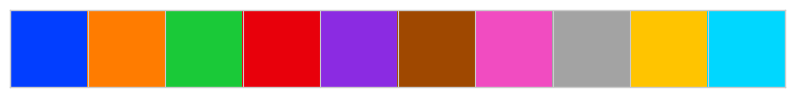

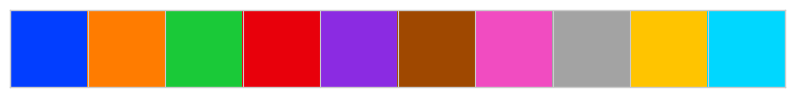

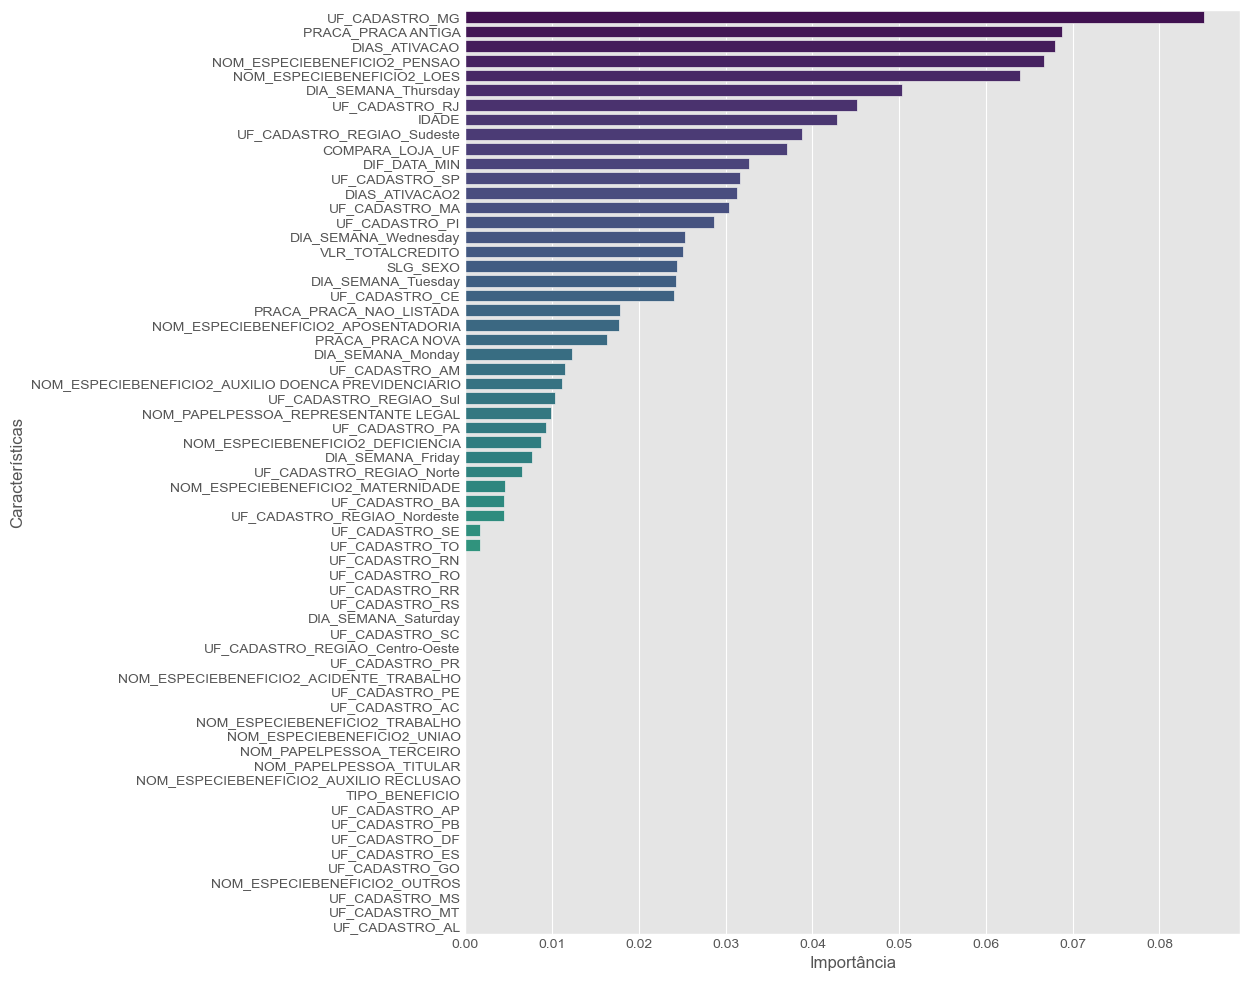

STATUS_WHO  Aprovação  Não_Analisado  Pendência  Reprovação
Y   pred                                                   
0.0 0.0          2780          78813         74           0
    1.0          1955          19440         94           0
1.0 0.0             0              5          0          14
    1.0             2              5          0          11

In [ ]:
colunas_escolhidas = [
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',

    'DIA_SEMANA',

    'DIF_DATA_MIN',

    'IDADE',

    'NOM_ESPECIEBENEFICIO2',

    'NOM_PAPELPESSOA',

    'PRACA',

    'SLG_SEXO',

    'TIPO_BENEFICIO',

    'UF_CADASTRO',
    # 'UF_CADASTRO_REGIAO',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    # 'VLR_TOTALCREDITO_1000em1000'
    ]
############################################################################################
x_treino = x_treino_bck.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]

x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

# modelo com todas todas variaveis

[I 2025-04-30 11:33:10,422] A new study created in memory with name: no-name-c6df236c-3f61-46ed-bb99-99ed3f4beeb0
[I 2025-04-30 11:33:26,499] Trial 0 finished with value: -248070.0 and parameters: {'learning_rate': 0.004801015478789861, 'n_estimators': 591}. Best is trial 0 with value: -248070.0.
[I 2025-04-30 11:34:14,740] Trial 1 finished with value: -293050.0 and parameters: {'learning_rate': 0.0428189868858604, 'n_estimators': 1314}. Best is trial 0 with value: -248070.0.
[I 2025-04-30 11:35:30,041] Trial 2 finished with value: -283130.0 and parameters: {'learning_rate': 0.01114148623953358, 'n_estimators': 2031}. Best is trial 0 with value: -248070.0.
[I 2025-04-30 11:35:34,322] Trial 3 finished with value: -735930.0 and parameters: {'learning_rate': 0.002493649273511803, 'n_estimators': 149}. Best is trial 0 with value: -248070.0.
[I 2025-04-30 11:35:50,197] Trial 4 finished with value: -250920.0 and parameters: {'learning_rate': 0.003257872546559508, 'n_estimators': 586}. Best i

Número do melhor trial: 19
Melhores hiperparâmetros: {'learning_rate': 0.0038047560776129277, 'n_estimators': 810}
Melhor valor da metrica de avaliação usada: -237520.0
DELTA: -237520


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
2,0.50,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
3,0.75,86618,16538,23,14,0.83951,0.00085,0.37838,0.83968,0.00169,165520,112000,184000,-237520
4,1.00,89263,13893,27,10,0.86511,0.00072,0.27027,0.86532,0.00143,139030,80000,216000,-275030
5,1.25,92003,11153,29,8,0.89164,0.00072,0.21622,0.89188,0.00143,111610,64000,232000,-279610
6,1.50,93975,9181,29,8,0.91075,0.00087,0.21622,0.91100,0.00173,91890,64000,232000,-259890
7,1.75,96160,6996,30,7,0.93191,0.00100,0.18919,0.93218,0.00199,70030,56000,240000,-254030
8,2.00,97384,5772,34,3,0.94374,0.00052,0.08108,0.94405,0.00103,57750,24000,272000,-305750
9,2.25,98024,5132,35,2,0.94993,0.00039,0.05405,0.95025,0.00077,51340,16000,280000,-315340


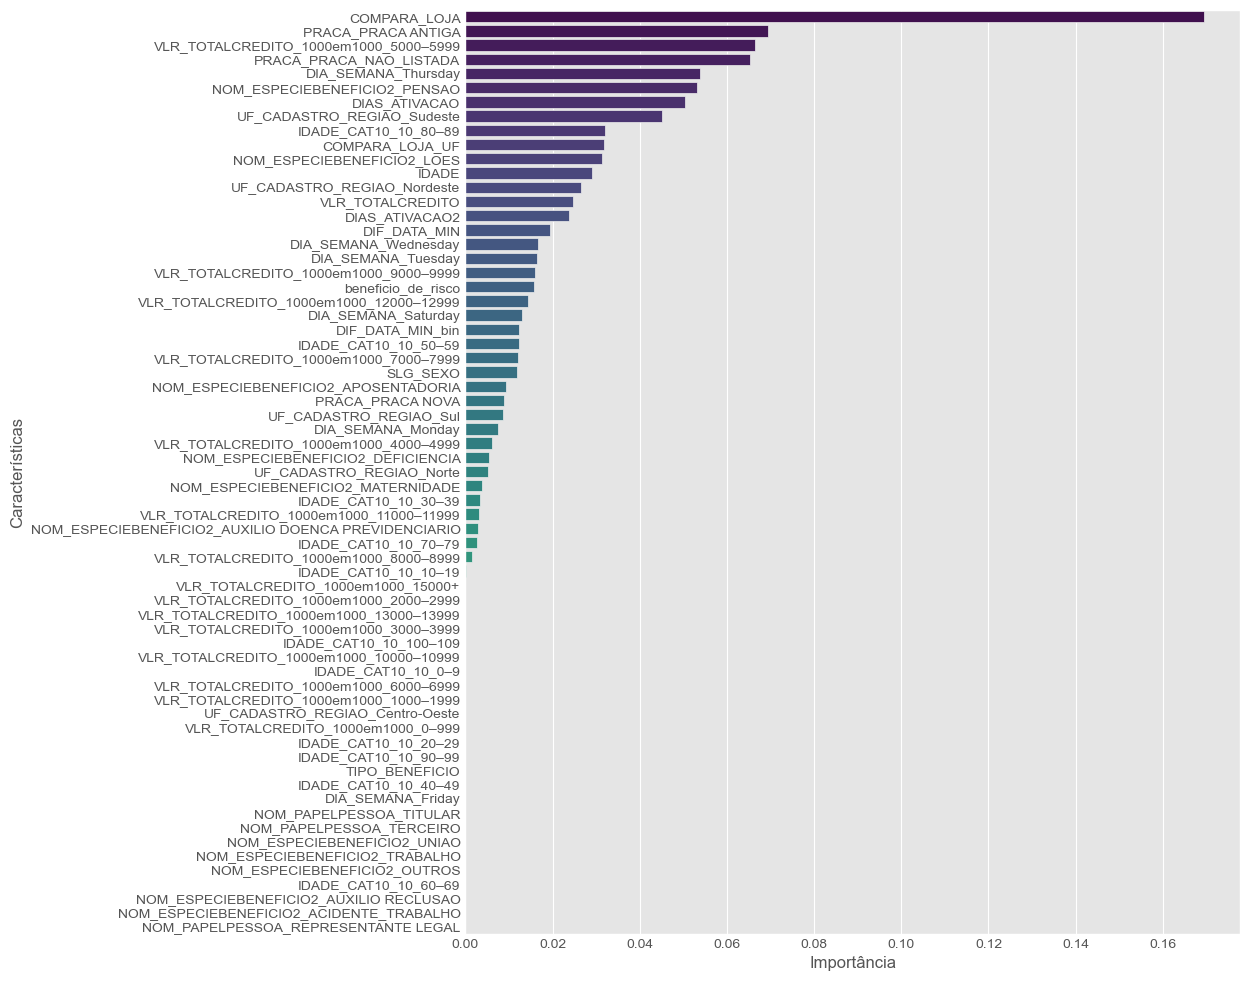

,STATUS_WHO,Aprovação,Não_Analisado,Pendência,Reprovação
Y,pred,,,,
0.0,1.0,4735,98253,168,0
1.0,1.0,2,10,0,25


In [42]:
colunas_escolhidas = [
    'COMPARA_LOJA',
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',
    'DIA_SEMANA_qtde_fraudes_6meses',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    # 'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]
############################################################################################
x_treino = x_treino_bck.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

DELTA: -226490


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
2,0.50,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
3,0.75,73841,29315,21,16,0.71572,0.00055,0.43243,0.71582,0.00109,293310,128000,168000,-333310
4,1.00,86122,17034,22,15,0.83472,0.00088,0.40541,0.83487,0.00176,170490,120000,176000,-226490
5,1.25,90981,12175,28,9,0.88175,0.00074,0.24324,0.88197,0.00147,121840,72000,224000,-273840
6,1.50,93542,9614,28,9,0.90656,0.00094,0.24324,0.90680,0.00186,96230,72000,224000,-248230
7,1.75,94277,8879,29,8,0.91368,0.00090,0.21622,0.91393,0.00179,88870,64000,232000,-256870
8,2.00,94970,8186,30,7,0.92038,0.00085,0.18919,0.92064,0.00170,81930,56000,240000,-265930
9,2.25,96259,6897,31,6,0.93286,0.00087,0.16216,0.93314,0.00173,69030,48000,248000,-269030


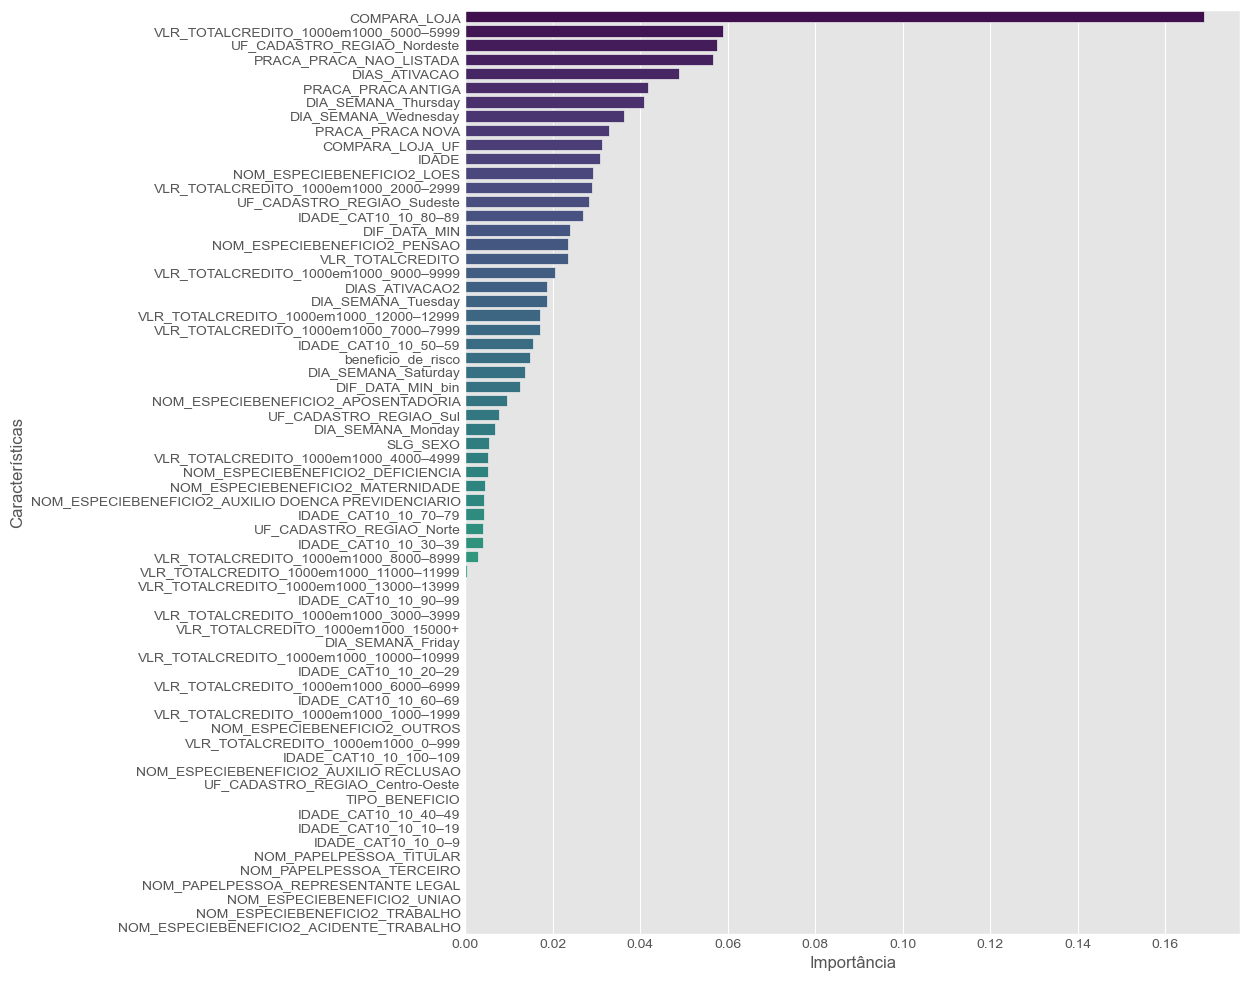

,STATUS_WHO,Aprovação,Não_Analisado,Pendência,Reprovação
Y,pred,,,,
0.0,1.0,4735,98253,168,0
1.0,1.0,2,10,0,25


In [46]:
colunas_escolhidas = [
    'COMPARA_LOJA',
    'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',
    'DIA_SEMANA_qtde_fraudes_6meses',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    # 'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]
############################################################################################
prop_x = int(len(x_treino_bck[x_treino_bck['Y'] == 0])*0.70)
x_treino_bck2 = pd.concat([ x_treino_bck[x_treino_bck['Y'] == 1], x_treino_bck[x_treino_bck['Y'] == 0].sample(prop_x, random_state=3141592) ])
y_treino_bck2 = y_treino_bck.loc[x_treino_bck2.index]

x_treino = x_treino_bck2.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

############################################################################################
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000)
    }
 
    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

# criando modelos

# aplicação diversos modelos

In [79]:
sem_random = 3141592

from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier

colunas_escolhidas = [
    'COMPARA_LOJA',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',
    # 'DIAS_ATIVACAO2_bin'
    # 'DIAS_ATIVACAO_bin',

    'DIA_SEMANA',

    'DIF_DATA_MIN',
    'DIF_DATA_MIN_bin',

    'IDADE',
    'IDADE_CAT10_10',
    # 'IDADE_CAT10_10_qtde_fraudes_6meses',

    # 'INDEXX',
    'NOM_ESPECIEBENEFICIO2',
    'NOM_ESPECIEBENEFICIO_qtde_fraudes_6meses',
    'beneficio_de_risco',
    'beneficios_que_tiveram_fraude',

    'NOM_PAPELPESSOA',

    'PRACA',

    # 'SCORE_UNICO',
    # 'SCORE_UNICO_CAT',
    # 'SCORE_UNICO_CAT_qtde_fraudes_6meses',

    'SLG_SEXO',

    # 'TELEFONE_COMPARTILHADO',

    'TIPO_BENEFICIO',

    #'UF_CADASTRO',

    'UF_CADASTRO_REGIAO',
    # 'UF_CADASTRO_REGIAO_qtde_fraudes_6meses',
    # 'UF_CADASTRO_qtde_fraudes_6meses',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    'VLR_TOTALCREDITO_1000em1000'#,
    #'VLR_TOTALCREDITO_500em500',
    #'VLR_TOTALCREDITO_bin',#

    # 'comparacao_cadastro_unico_e_bene'
    ]

colunas_escolhidas = [
'COMPARA_LOJA_UF',

    'DIAS_ATIVACAO',
    'DIAS_ATIVACAO2',

    'DIA_SEMANA',

    'DIF_DATA_MIN',

    'IDADE',

    'NOM_ESPECIEBENEFICIO2',

    'NOM_PAPELPESSOA',

    'PRACA',

    'SLG_SEXO',

    'TIPO_BENEFICIO',

    'UF_CADASTRO',
    # 'UF_CADASTRO_REGIAO',

    # 'UF_LOJA_ATIVACAO',
    # 'UF_LOJA_ATIVACAO_qtde_fraudes_6meses',
    # 'UF_LOJA_OFICIAL',

    'VLR_TOTALCREDITO',
    # 'VLR_TOTALCREDITO_1000em1000'
]
############################################################################################
prop_x = int(len(x_treino_bck[x_treino_bck['Y'] == 0])*0.80)
x_treino_bck2 = pd.concat([ x_treino_bck[x_treino_bck['Y'] == 1], x_treino_bck[x_treino_bck['Y'] == 0].sample(prop_x, random_state=3141592) ])
y_treino_bck2 = y_treino_bck.loc[x_treino_bck2.index]

x_treino = x_treino_bck2.loc[:, x_selecionando_colunas(x_treino_bck, colunas_escolhidas)]
x_teste = x_teste_bck.loc[:, x_selecionando_colunas(x_teste_bck, colunas_escolhidas)]
x_colunas = x_treino.columns.to_list()
x_treino = x_treino.to_numpy()
x_teste = x_teste.to_numpy()

### XGBClassifier

In [80]:
n_0 = (df['Y'] == 0).sum()
n_1 = (df['Y'] == 1).sum()
scale_pos_weight = n_1 / n_0
scale_pos_weight = scale_pos_weight.round(5)
scale_pos_weight

0.00035

[I 2025-04-30 16:23:46,361] A new study created in memory with name: no-name-004e1351-9617-4834-a77c-43c27e494ce3
[I 2025-04-30 16:24:54,743] Trial 0 finished with value: -282520.0 and parameters: {'learning_rate': 0.07926456490720284, 'n_estimators': 1650, 'max_depth': 15}. Best is trial 0 with value: -282520.0.
[I 2025-04-30 16:25:49,975] Trial 1 finished with value: -288220.0 and parameters: {'learning_rate': 0.04993815706920133, 'n_estimators': 1866, 'max_depth': 7}. Best is trial 0 with value: -282520.0.
[I 2025-04-30 16:26:55,292] Trial 2 finished with value: -292380.0 and parameters: {'learning_rate': 0.008572011904608904, 'n_estimators': 1806, 'max_depth': 11}. Best is trial 0 with value: -282520.0.
[I 2025-04-30 16:27:39,525] Trial 3 finished with value: -259180.0 and parameters: {'learning_rate': 0.0027421395082843076, 'n_estimators': 1770, 'max_depth': 6}. Best is trial 3 with value: -259180.0.
[I 2025-04-30 16:28:47,520] Trial 4 finished with value: -281810.0 and parameters

Número do melhor trial: 25
Melhores hiperparâmetros: {'learning_rate': 0.001832044918835639, 'n_estimators': 1246, 'max_depth': 7}
Melhor valor da metrica de avaliação usada: -229210.0
DELTA: -229210


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
2,0.50,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
3,0.75,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
4,1.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
5,1.25,81053,22103,19,18,0.78562,0.00081,0.48649,0.78573,0.00162,221210,144000,152000,-229210
6,1.50,86954,16202,26,11,0.84274,0.00068,0.29730,0.84294,0.00135,162130,88000,208000,-282130
7,1.75,89519,13637,29,8,0.86757,0.00059,0.21622,0.86780,0.00117,136450,64000,232000,-304450
8,2.00,91134,12022,29,8,0.88322,0.00067,0.21622,0.88346,0.00133,120300,64000,232000,-288300
9,2.25,92344,10812,30,7,0.89493,0.00065,0.18919,0.89519,0.00129,108190,56000,240000,-292190


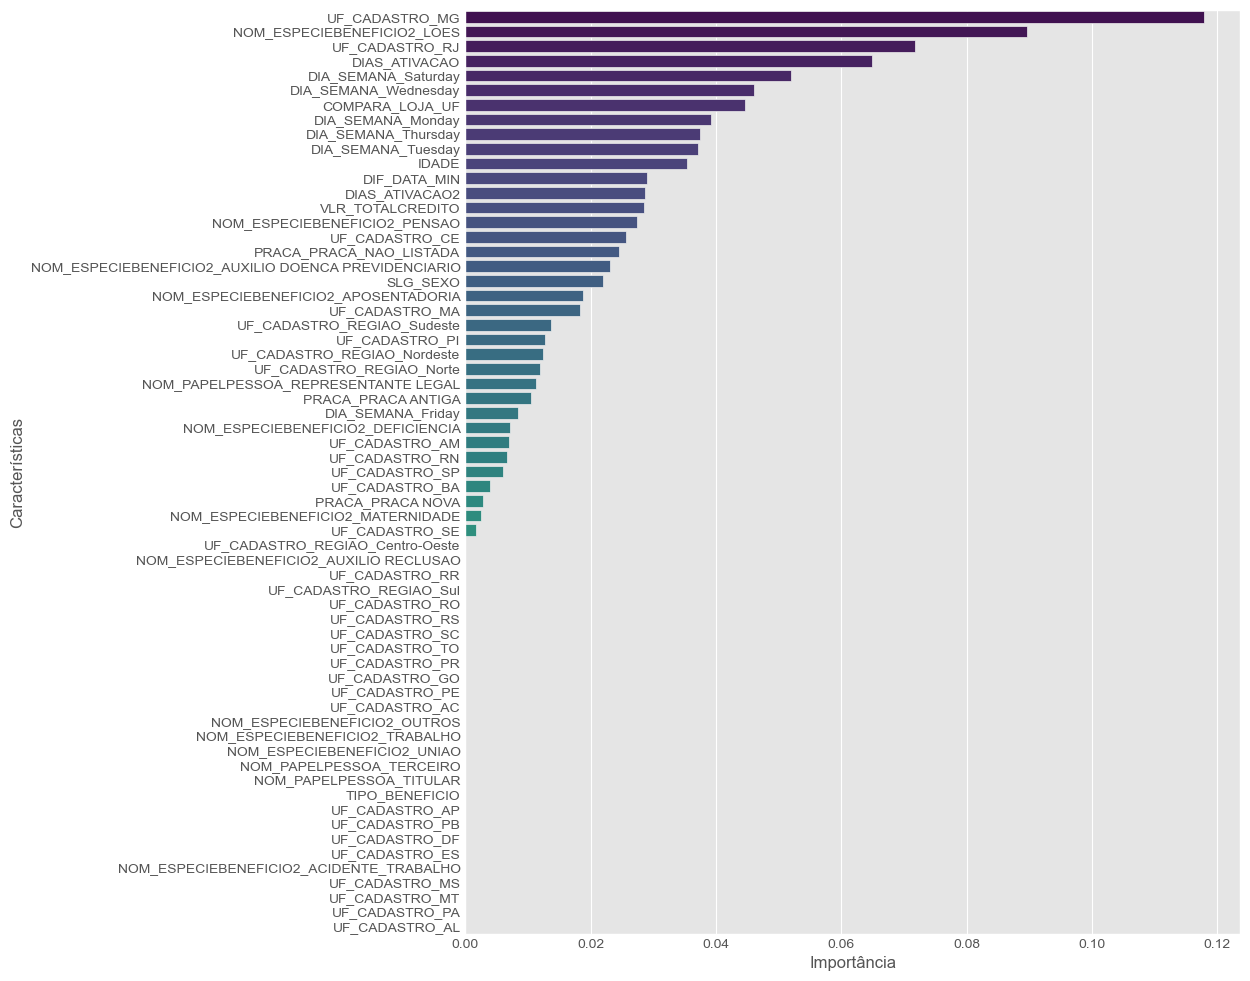

,STATUS_WHO,Aprovação,Não_Analisado,Pendência,Reprovação
Y,pred,,,,
0.0,1.0,4735,98253,168,0
1.0,1.0,2,10,0,25


In [ ]:
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 6, 15),

        'random_state': grandom_state,
        'n_jobs': -1
    }

    # Criando uma nova instância do modelo com os parâmetros sugeridos
    modelo = XGBClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_XGBClassifier = XGBClassifier(**study.best_trial.params)
modelo_XGBClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_XGBClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_XGBClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

### XGBRFClassifier

In [97]:
dados_consolidados = pd.read_parquet('x_tratados_bck_score0.parquet')
dados_consolidados.to_csv('x_tratados_bck_score0.csv', sep=';', index=False)

In [88]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        # "num_parallel_tree": trial.suggest_int("num_parallel_tree", 100, 3000),  # equivalente a n_estimators
        # "max_depth": trial.suggest_int("max_depth", 6, 15),
        
        'random_state': grandom_state,
        'n_jobs': -1
    }

    modelo = XGBRFClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_XGBRFClassifier = XGBRFClassifier(**study.best_trial.params)
modelo_XGBRFClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_XGBRFClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_XGBRFClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

[I 2025-04-30 17:49:15,643] A new study created in memory with name: no-name-dc6ad639-617c-4286-9e31-82600d5be973
[I 2025-04-30 17:49:19,709] Trial 0 finished with value: -735930.0 and parameters: {'learning_rate': 0.008064765039845122}. Best is trial 0 with value: -735930.0.
[I 2025-04-30 17:49:23,560] Trial 1 finished with value: -735930.0 and parameters: {'learning_rate': 0.003111593108631534}. Best is trial 0 with value: -735930.0.
[I 2025-04-30 17:49:27,637] Trial 2 finished with value: -735930.0 and parameters: {'learning_rate': 0.018307700285098847}. Best is trial 0 with value: -735930.0.
[I 2025-04-30 17:49:31,658] Trial 3 finished with value: -735930.0 and parameters: {'learning_rate': 0.045862893813438436}. Best is trial 0 with value: -735930.0.
[I 2025-04-30 17:49:36,041] Trial 4 finished with value: -735930.0 and parameters: {'learning_rate': 0.00491666624454576}. Best is trial 0 with value: -735930.0.
[I 2025-04-30 17:49:40,349] Trial 5 finished with value: -735930.0 and p

KeyboardInterrupt: 

### HistGradientBoostingClassifier

In [ ]:
def objective(trial):
    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 200),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 255),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'max_iter': 100,
        'random_state': grandom_state
    }

    modelo = HistGradientBoostingClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_HistGradientBoostingClassifier = HistGradientBoostingClassifier(**study.best_trial.params)
modelo_HistGradientBoostingClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_HistGradientBoostingClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_HistGradientBoostingClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

TypeError: HistGradientBoostingClassifier.__init__() got an unexpected keyword argument 'colsample_bynode'

### LGBMClassifier

[I 2025-04-30 13:24:12,423] A new study created in memory with name: no-name-a1ff02b5-1ec9-4abf-b14b-7953c4ebfde5
[I 2025-04-30 13:24:29,485] Trial 0 finished with value: -246650.0 and parameters: {'num_leaves': 106, 'learning_rate': 0.10931477783562475, 'min_child_samples': 16}. Best is trial 0 with value: -246650.0.
[I 2025-04-30 13:24:46,370] Trial 1 finished with value: -246650.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.2253983317640434, 'min_child_samples': 56}. Best is trial 0 with value: -246650.0.
[I 2025-04-30 13:25:04,765] Trial 2 finished with value: -246650.0 and parameters: {'num_leaves': 98, 'learning_rate': 0.06941266044612358, 'min_child_samples': 37}. Best is trial 0 with value: -246650.0.
[I 2025-04-30 13:25:20,565] Trial 3 finished with value: -246650.0 and parameters: {'num_leaves': 101, 'learning_rate': 0.11819324364206801, 'min_child_samples': 44}. Best is trial 0 with value: -246650.0.
[I 2025-04-30 13:25:36,531] Trial 4 finished with value: -246650.

Número do melhor trial: 0
Melhores hiperparâmetros: {'num_leaves': 106, 'learning_rate': 0.10931477783562475, 'min_child_samples': 16}
Melhor valor da metrica de avaliação usada: -246650.0
[LightGBM] [Info] Number of positive: 192, number of negative: 487507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 487699, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000394 -> initscore=-7.839565
[LightGBM] [Info] Start training from score -7.839565
DELTA: -302630


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,102431,725,37,0,0.99262,0.00000,0,0.99297,0.00000,7250,0,296000,-303250
2,0.50,102481,675,37,0,0.99310,0.00000,0,0.99346,0.00000,6750,0,296000,-302750
3,0.75,102481,675,37,0,0.99310,0.00000,0,0.99346,0.00000,6750,0,296000,-302750
4,1.00,102485,671,37,0,0.99314,0.00000,0,0.99350,0.00000,6710,0,296000,-302710
5,1.25,102486,670,37,0,0.99315,0.00000,0,0.99350,0.00000,6700,0,296000,-302700
6,1.50,102487,669,37,0,0.99316,0.00000,0,0.99351,0.00000,6690,0,296000,-302690
7,1.75,102489,667,37,0,0.99318,0.00000,0,0.99353,0.00000,6670,0,296000,-302670
8,2.00,102490,666,37,0,0.99319,0.00000,0,0.99354,0.00000,6660,0,296000,-302660
9,2.25,102491,665,37,0,0.99320,0.00000,0,0.99355,0.00000,6650,0,296000,-302650


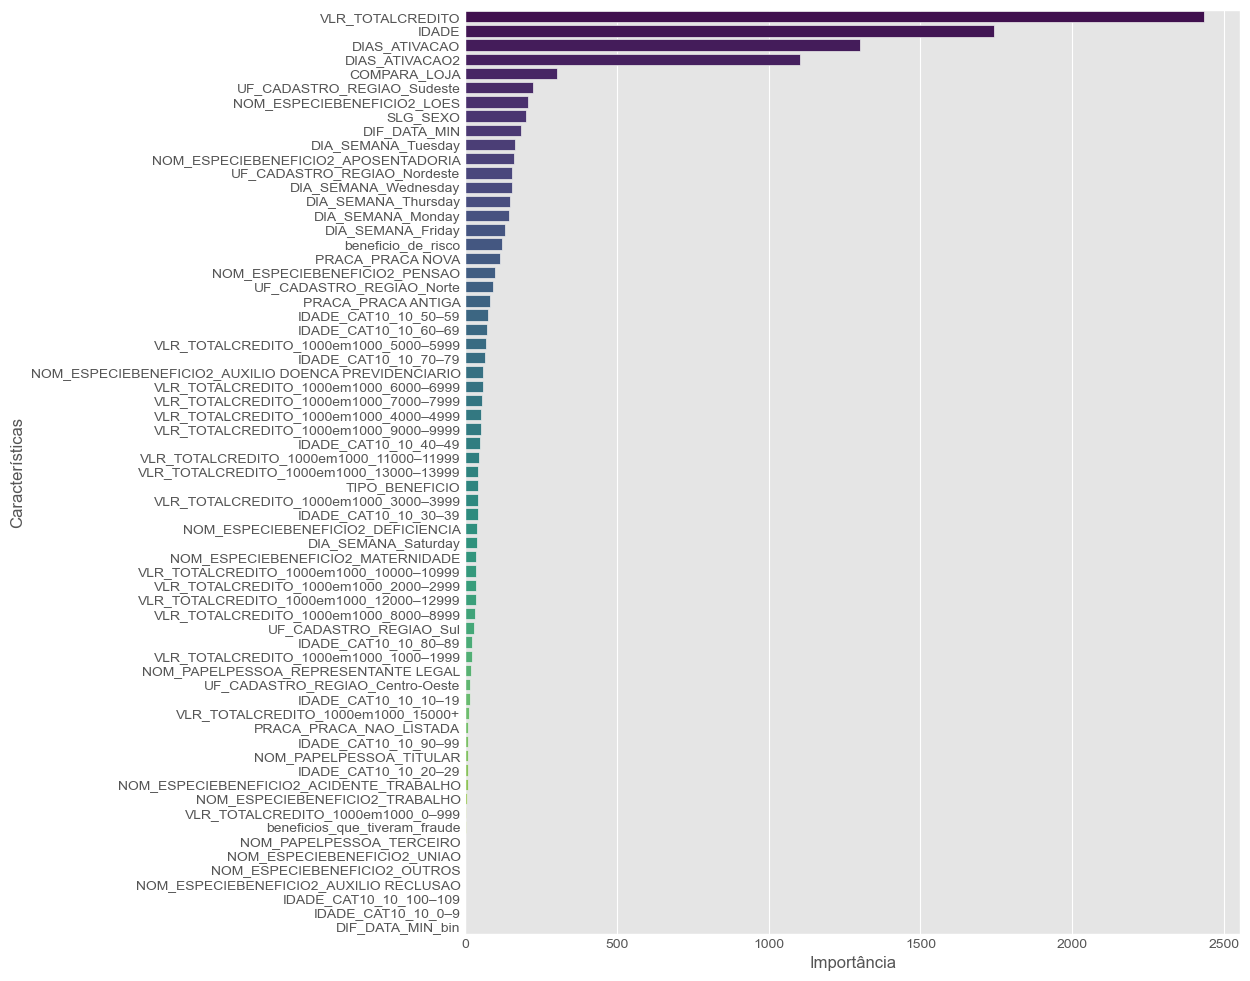

STATUS_WHO  Aprovação  Não_Analisado  Pendência  Reprovação
Y   pred                                                   
0.0 0.0          4702          97565        164           0
    1.0            33            688          4           0
1.0 0.0             2             10          0          25

In [ ]:
def objective(trial):
    params = {
        'scale_pos_weight': n_0 / n_1,  # OU use 'is_unbalance': True, mas não ambos
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'learning_rate': 0.1,
        'n_estimators': 100,
        'random_state': grandom_state,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    modelo.fit(x_treino, y_treino_bck2)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões # predictions = modelo.predict(x_teste) # metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)
    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
    metrica = tabela['delta'].max() # fb_score
    return metrica

# # Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor da metrica de avaliação usada:', study.best_trial.value)

# Recriando modelo 
modelo_LGBMClassifier = LGBMClassifier(**study.best_trial.params)
modelo_LGBMClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_LGBMClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_LGBMClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

[LightGBM] [Info] Number of positive: 192, number of negative: 557151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 557343, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000344 -> initscore=-7.973096
[LightGBM] [Info] Start training from score -7.973096
DELTA: -235880


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,fraude_tomada,delta
0,0.00,0,103156,0,37,0.00036,0.00036,1.00000,0.00000,0.00072,1031930,296000,0,-735930
1,0.25,95876,7280,29,8,0.92917,0.00110,0.21622,0.92943,0.00218,72880,64000,232000,-240880
2,0.50,96376,6780,29,8,0.93402,0.00118,0.21622,0.93427,0.00234,67880,64000,232000,-235880
3,0.75,98814,4342,31,6,0.95762,0.00138,0.16216,0.95791,0.00274,43480,48000,248000,-243480
4,1.00,100970,2186,33,4,0.97850,0.00183,0.10811,0.97881,0.00359,21900,32000,264000,-253900
5,1.25,101723,1433,33,4,0.98579,0.00278,0.10811,0.98611,0.00543,14370,32000,264000,-246370
6,1.50,101968,1188,33,4,0.98817,0.00336,0.10811,0.98848,0.00651,11920,32000,264000,-243920
7,1.75,102045,1111,33,4,0.98891,0.00359,0.10811,0.98923,0.00694,11150,32000,264000,-243150
8,2.00,102117,1039,33,4,0.98961,0.00384,0.10811,0.98993,0.00741,10430,32000,264000,-242430
9,2.25,102163,993,35,2,0.99004,0.00201,0.05405,0.99037,0.00388,9950,16000,280000,-273950


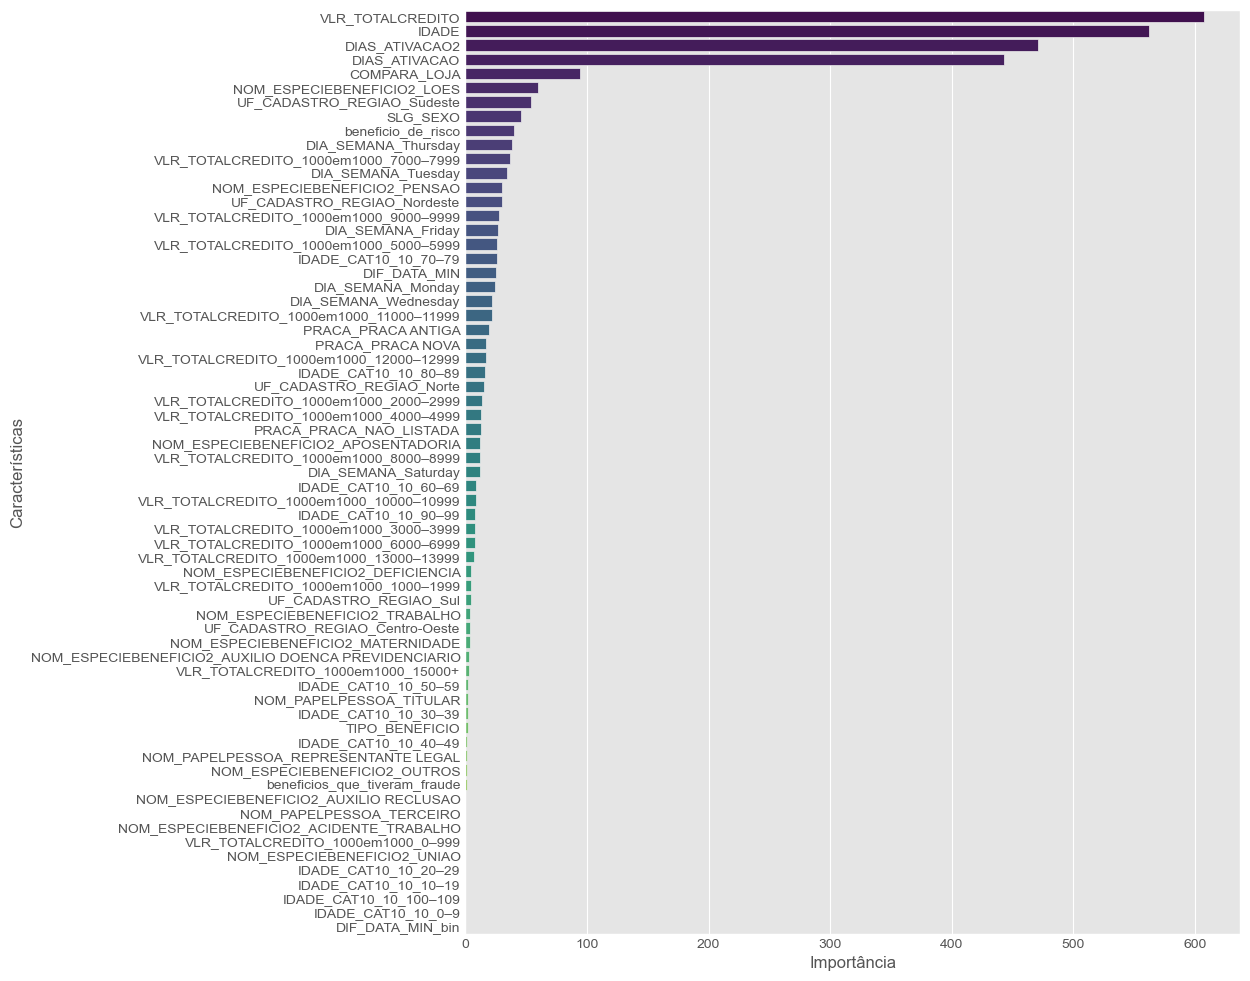

STATUS_WHO  Aprovação  Não_Analisado  Pendência  Reprovação
Y   pred                                                   
0.0 0.0          4175          91561        140           0
    1.0           560           6692         28           0
1.0 0.0             1             10          0          18
    1.0             1              0          0           7

In [76]:
# Recriando modelo 
modelo_LGBMClassifier = LGBMClassifier()
modelo_LGBMClassifier.fit(x_treino, y_treino_bck2)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

############################################################################################
y_probs_positivas = modelo_LGBMClassifier.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste_bck, y_probs_positivas, pontos_de_corte = np.arange(0, 3.1, 0.25))
print('DELTA:', tabela['delta'].max())
display(tabela)

tabela_feat = feature_importance_emsamble(modelo_LGBMClassifier, x_colunas )
plot_importancias(tabela_feat)

############################################################
df_colunas_excluidas.loc[x_teste_bck.index, 'Y'] = y_teste_bck
df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where(y_probs_positivas >= 0.25, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:




# Criar dicionário com todos os modelos
model_dict = {
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=sem_random),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=sem_random),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=sem_random),
    'XGBClassifier': XGBClassifier(random_state=sem_random),
    'LGBMClassifier': LGBMClassifier(random_state=sem_random)
}

import time
# Treinando todos os modelos
tab_modelo_treinados = pd.DataFrame(columns=['Modelo', 'Status', 'Tempo'])
for model_name, model_instance in model_dict.items():
    print(model_name)
    try:

        start_time = time.time()
        model_instance.fit(x_treino, y_treino_bck2) # <- modelo treinado
        end_time = time.time()
        training_time = end_time - start_time

        tab_modelo_treinados.loc[len(tab_modelo_treinados)] = [model_name, 'OK', training_time]
        print('ok')
    except Exception as e:
        print('prob')
        tab_modelo_treinados.loc[len(tab_modelo_treinados)] = [model_name, 'Erro', np.nan]
        #del model_dict[model_name] # excluindo do dicionario # não pode modificar o dicionario durante iteracao
display(tab_modelo_treinados)

In [ ]:
def adicionar_previsoes(x_teste, y_teste, **modelos):
    # Inicializa o DataFrame com a coluna `y`
    df = pd.DataFrame({'y': y_teste})

    # Para cada modelo, gera previsões e adiciona ao DataFrame
    for nome, modelo in modelos.items():
        try:
        #if hasattr(modelo, "predict_proba"):
            df[nome] = modelo.predict_proba(x_teste)[:, 1] * 100
        except:
            print('erro:', nome)

    return df

previsoes = adicionar_previsoes(x_teste, y_teste_bck, **model_dict)
previsoes.sample(3)

In [ ]:
beta = 1.5

lista_modelos = list(previsoes.columns)
lista_modelos.remove('y')
lista_modelos

fd = pd.DataFrame(columns=['modelo', 'threshold', 'tn', 'fp', 'fn', 'tp'])

for modelo in lista_modelos:
    fdzinho = aval_modelo_corte_tabela(previsoes['y'], previsoes[modelo], pontos_de_corte = np.arange(0, 3.1, 0.25))
    fdzinho['modelo'] = modelo

    fd = pd.concat([fd, fdzinho])

# Substituir valores NaN por 0
#fd.fillna(0, inplace=True)
fd = fd.reset_index(drop=True)
display(fd.sort_values(by='f1', ascending=False).head(10))
display(fd.sort_values(by='delta', ascending=False).head(10))

In [ ]:
from itertools import combinations

melhores_modelo6 = fd.sort_values(by='delta', ascending=False)['modelo'].unique()[:6]
# Gerando todas as combinações de 3 itens
combinacoes_modelos = list(combinations(melhores_modelo6, 3))
len(combinacoes_modelos)

In [ ]:
grade_thresholds = pd.DataFrame()

for i in range(len(combinacoes_modelos)):
    print('combinacao n:', i)

    lista = list(combinacoes_modelos[i])
    nome_combinacao = "\n".join(lista)

    modelos_escolhidos = lista
    modelos_escolhidos.append('y')

    fd_previsoes = previsoes[modelos_escolhidos]

    grade_thresholds_temp = gridsearch_mult_models_threshold(fd_previsoes, beta=1.5, linspace_thresholds = np.arange(0, 3.1, 0.25))
    grade_thresholds_temp['nome_comp'] = nome_combinacao
    grade_thresholds_temp['m1'] = lista[0]
    grade_thresholds_temp['m2'] = lista[1]
    grade_thresholds_temp['m3'] = lista[2]

    grade_thresholds = pd.concat([grade_thresholds, grade_thresholds_temp])

display(grade_thresholds)#.sort_values(by='delta', ascending=False).head(10))

In [ ]:
grade_thresholds['custo_who'] = (grade_thresholds['tp'] + grade_thresholds['fp']) * 10.0
grade_thresholds['fraude_evitada'] = grade_thresholds['tp'] * 8000
grade_thresholds['fraude_tomada'] = grade_thresholds['fn'] * 8000
grade_thresholds['delta'] = grade_thresholds['fraude_evitada'] - grade_thresholds['custo_who'] - grade_thresholds['fraude_tomada']
display(grade_thresholds.sort_values(by='delta', ascending=False).head(10))

In [ ]:
criterio_m1 = np.where(previsoes['GradientBoostingClassifier'] >= 0.5, 1, 0)
criterio_m2 = np.where(previsoes['LGBMClassifier'] >= 0.25, 1, 0)
criterio_m3 = np.where(previsoes['RandomForestClassifier'] >= 0.25, 1, 0)

df_colunas_excluidas.loc[x_teste_bck.index, 'pred'] = np.where((criterio_m1 + criterio_m2 + criterio_m3) >= 2, 1, 0)
df_colunas_excluidas.groupby(['Y','pred','STATUS_WHO']).size().unstack().fillna(0).astype(int)

In [ ]:
previsoes

In [ ]:
['STATUS_WHO']

In [ ]:
stop

#### modelo com as variaveis naturais

In [ ]:
stop

# Otimizando parametros

In [ ]:
import optuna
from sklearn.metrics import fbeta_score
 
def objective(trial):
    # Sugerindo um número de estimadores entre 10 e 100
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 3000)
    }
 
    # Criando uma nova instância do BaggingClassifier com os parâmetros sugeridos
    modelo = XGBClassifier(**params, random_state=grandom_state, n_jobs=-1)
    modelo.fit(x_treino, y_treino)  # Certifique-se de que x_treino e y_treino estão definidos
 
    # Fazendo previsões
    #predictions = modelo.predict(x_teste)
    #metrica = fbeta_score(y_pred=predictions, y_true=y_teste, beta=1.5)

    y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
    # tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas)
    tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
    metrica = tabela['fb_score'].max()
 
    return metrica
 
# Criação do estudo para maximizar a metrica de avaliação do modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Melhor resultado
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor de recall:', study.best_trial.value)

# Recriando modelo 
modelo = XGBClassifier(**study.best_trial.params, random_state=grandom_state, n_jobs=-1)
modelo.fit(x_treino, y_treino)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

In [ ]:
print('Número do melhor trial:', study.best_trial.number)
print('Melhores hiperparâmetros:', study.best_trial.params)
print('Melhor valor de recall:', study.best_trial.value)

In [ ]:
modelo = joblib.load('modelo_otimizado.pkl')

y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
print(tabela['fb_score'].max())
tabela.to_excel('resultado_modelo_otimizado.xlsx', index=False)
display(tabela)

In [ ]:
modelo = XGBClassifier(random_state=grandom_state,
                       **study.best_trial.params)
modelo.fit(x_treino, y_treino)
# joblib.dump(modelo, 'modelo_otimizado.pkl') # Salvar modelo com joblib

y_probs_positivas = modelo.predict_proba(x_teste)[:,1]*100
tabela = aval_modelo_corte_tabela(y_teste, y_probs_positivas, pontos_de_corte = np.arange(0, 40, 2.5))
print(tabela['fb_score'].max())
display(tabela)